![USF Logo](../Presentation_Graphics/COVID_Video_Thumnail.png)

<h1 style="text-align:center">Developing a Multi-State Modeling Using Near Real-time</h1>
<h1 style="text-align:center">Florida COVID-19 Data</h1>
<h2 style="text-align:center">Daniel Chacreton MPH, CIC, CPH</h2>


> PHC 7910: Directed Research

> University of South Florida 

> College of Public Health

> Global Communicable Disease


>> 7/25/20

![USF Logo](../Presentation_Graphics/usfhealth_logo.png)

# Objectives
1. [ ] Discuss Project Purpose
- [ ] Describe Methods
- [ ] Describe Preliminary Results
- [ ] Review Conclusions & Next Steps

# Purpose

<img src="../Presentation_graphics/Florida_COVID_DB.png" alt="Florida Flag" width="1000"/>

>Source: Florida Department of Health COVID-19 Dashboard


# AIM:
- Explain the relationship between the COVID-19 PPR and the public health control measures intended to control the spread of the SARS-COV-2 pandemic in the state of Florida (MSM).

## Variable of Interest:

- State Reopening Phase
    - Phase 1 Start: **5/4/2020**
    - Phase 2 Start: **6/5/2020**

### Control Variables:
    - County level Median Age
    - County Level Health Factors
        - Smoking
        - Diabetes
        - Obesity

<h1 style="text-align:center">Methods</h1>


![](https://www.kdnuggets.com/wp-content/uploads/text-data-task-framework.png)
> Source: https://www.kdnuggets.com/2017/12/general-approach-preprocessing-text-data.html

## Data Collection Process
>1. Download PDF data from DEM archive.
2. Extract relevant PDF pages.
<img src="../Presentation_Graphics/data_collection1.png" alt="Florida Flag" width="600"/>
3. Convert PDFs to html file
4. compile htmls into a Pandas dataframe
5. Clean and manipluate data
6. Merge in covariates
<img src="../Presentation_Graphics/data_collection2.png" alt="Florida Flag" width="600"/>
7. Export completed data set for analysis
<img src="../Presentation_Graphics/data_collection3.png" alt="Florida Flag" width="600"/>

# 1. Downloading COVID Data From FloridaDisaster.ORG

In [348]:
from selenium import webdriver
import os
import wget
import PyPDF2 as pdf
from PyPDF2 import PdfFileReader, PdfFileWriter
import time
import textract
from pathlib import Path
import re
import pandas as pd
import datetime

In [349]:
chrome_path = r"chromedriver.exe"

> ## 1a. Initializing driver element and finding new PDFs

In [350]:
driver = webdriver.Chrome(chrome_path)

In [351]:
driver.get('https://floridadisaster.org/covid19/covid-19-data-reports/')
title = driver.title
time.sleep(3)
result = driver.find_elements_by_xpath("//a[@href]")
report_months= ['June Reports', 'May Reports', 'April Reports', 'March Reports']
expanded = 0
if expanded == 0:
    for item in result:
        for months in report_months:
            if item.text.find(months) >= 0:
                item.click()
                expanded = 1
time.sleep(3)
result_full = driver.find_elements_by_xpath("//a[@href]")

StaleElementReferenceException: Message: stale element reference: element is not attached to the page document
  (Session info: chrome=84.0.4147.89)


Initializing the output paths

In [354]:
output_path = Path('../data/PDF')
pdf_output_path= output_path.resolve()
pdf_extract_path = Path('../Data/Unclean PDF')
pdf_extract_path = pdf_extract_path.resolve()

In [355]:
pdf_output_path

WindowsPath('C:/Users/chacr/OneDrive/Documents/Coding/COVID-19 Project/Data/PDF')

> ## 1b. Downloads the PDF Files from FloridaDisaster.ORG

In [13]:
print('Starting Data Download')
link_counter = 0
download_counter = 0 
link_n = len(result_full) -152
download_list = []
for links in result_full:
    if links.text.find('Data Report') > 0:
        link_url = links.get_attribute('href')
        filename = wget.filename_from_url(link_url)
        if not os.path.exists(f'{pdf_output_path}/{filename}'):
            wget.download(link_url, out = f'{pdf_output_path}')
            download_counter += 1
            download_list.append
            print("Downloading", links.text)
        link_counter +=1
        print (f'{round((link_counter)*100/link_n,2)}% Complete')
print('Download of New Files Complete')
print(f'{download_counter} Files Created')

Starting Data Download
0.6% Complete
1.2% Complete
1.8% Complete
2.4% Complete
2.99% Complete
3.59% Complete
4.19% Complete
4.79% Complete
5.39% Complete
5.99% Complete
6.59% Complete
7.19% Complete
7.78% Complete
8.38% Complete
8.98% Complete
9.58% Complete
10.18% Complete
10.78% Complete
11.38% Complete
11.98% Complete
12.57% Complete
13.17% Complete
13.77% Complete
14.37% Complete
14.97% Complete
15.57% Complete
16.17% Complete
16.77% Complete
17.37% Complete
17.96% Complete
18.56% Complete
19.16% Complete
19.76% Complete
20.36% Complete
20.96% Complete
21.56% Complete
22.16% Complete
22.75% Complete
23.35% Complete
23.95% Complete
24.55% Complete
25.15% Complete
25.75% Complete
26.35% Complete
26.95% Complete
27.54% Complete
28.14% Complete
28.74% Complete
29.34% Complete
29.94% Complete
30.54% Complete
31.14% Complete
31.74% Complete
32.34% Complete
32.93% Complete
33.53% Complete
34.13% Complete
34.73% Complete
35.33% Complete
35.93% Complete
36.53% Complete
37.13% Complete
37.72

In [352]:
driver.close()

# 2. Extracting the min and max page range for the COVID-19 Daily County Data

In [356]:
#turn into a function
def PdfPageExtract(input_path, output_path, page_num):
    import time
    import os
    import PyPDF2 as pdf
    from PyPDF2 import PdfFileReader, PdfFileWriter
    import textract
    import re
    pdf_extract_list = []
    date_fmt = r'(^.+\D)_(\d+)_(\d+)(\.pdf\Z)'
    print('Program Started')
    page_counter = 0
    today = datetime.date.today()
    file_num = len(os.listdir(input_path))
    file_exist_n =0
    progress = 0
    for files in os.listdir(input_path):
        if re.search(date_fmt, files ):
#             print(files) 
            mod_files = re.sub(date_fmt, r'\1 \2-\3-2020.pdf', files )
#             print(mod_files)    
            output = f'{output_path}/(7-11-20) Unclean Extract from {mod_files}'
        else:
            output = f'{output_path}/(7-11-20) Unclean Extract from {files}'
        progress += 1
        if os.path.exists(output):
            file_exist_n +=1
            print(f'{round((progress/file_num)* 100,2)}%', 'Complete', 'File exists')
            continue
        else:
            print('Creating the file', output)
            pdf_writer = PdfFileWriter()
            pdf_file = open(f'{input_path}/{files}','rb')
            pdfreader = PdfFileReader(pdf_file)
            num_pages = pdfreader.numPages
            if num_pages < page_num:
                up_limit = num_pages
            else:
                up_limit = page_num
            for pages in range(3, up_limit):
                page =  pdfreader.getPage(pages)  
                if page.extractText().find('COVID-19: All persons with tests reported') > 0 or page.extractText().find('Coronavirus: PUI testing by county') > 0 or page.extractText().find('Coronavirus: All persons tested') > 0 or page.extractText().find('Coronavirus: PUI testing by county') > 0 or page.extractText().find('Coronavirus: All') > 0:
                    pdf_writer.addPage(page) 
            
            with open(output, 'wb') as output_pdf:
                pdf_writer.write(output_pdf)
            pdf_extract_list.append(files)
            print(f'{round((progress/file_num)* 100,2)}% ', 'Complete' , 'File created')
    
    if file_exist_n == file_num:
        print('All Files Previously Created')
    else:
        print(f'{file_num -file_exist_n} New Files Created')
    return pdf_extract_list

page_limit = 26

PdfPageExtract(pdf_output_path, pdf_extract_path, page_limit)


Program Started
0.61% Complete File exists
1.21% Complete File exists
1.82% Complete File exists
2.42% Complete File exists
3.03% Complete File exists
3.64% Complete File exists
4.24% Complete File exists
4.85% Complete File exists
5.45% Complete File exists
6.06% Complete File exists
6.67% Complete File exists
7.27% Complete File exists
7.88% Complete File exists
8.48% Complete File exists
9.09% Complete File exists
9.7% Complete File exists
10.3% Complete File exists
10.91% Complete File exists
11.52% Complete File exists
12.12% Complete File exists
12.73% Complete File exists
13.33% Complete File exists
13.94% Complete File exists
14.55% Complete File exists
15.15% Complete File exists
15.76% Complete File exists
16.36% Complete File exists
16.97% Complete File exists
17.58% Complete File exists
18.18% Complete File exists
18.79% Complete File exists
19.39% Complete File exists
20.0% Complete File exists
20.61% Complete File exists
21.21% Complete File exists
21.82% Complete File ex

[]

# 3. Converting the PDFs to html files

In [357]:
from pathlib import Path

input_path = Path('../Data/Unclean PDF')
output_path = Path('../Data/html')
ip = input_path.resolve()
op = output_path.resolve()

In [358]:
import os
import pdftotree
import re
import sys
print('Program started')
html_created_list= []
file_n = len(os.listdir(ip))
file_ct = 0
file_exist_n =0
error_list = []
date1 = r'^.*(\d{2})-*(\d{2})-*(\d{4}).*\Z'
date2 = r'^.*(\d+)_(\d+)_(\d+).*\Z'
date3 = r'^.*(\d{4})-*(\d{2})-*(\d{2}).*\Z'
date4 = r'^.*\D(\d)\.(\d+)\.(\d+).*\Z'
date5 = r'^.*(\d{2})_(\d{2})\Z'
date6 = r'^.*-(\d{1})(\d{2})(\d{2})_.*\Z'
# date_format = r'(^.+)\D(\d-)(.*\Z)'
last_file_name = ''
for files in os.listdir(ip):
    file_ct += 1
    if re.search(date3,files):
#     test_name = re.sub(date3, r'html version of FL COVID Rep \2-\3-\1.html',files)
#     if 
        match = 1
        new_file_name = re.sub(date3, r'html version of FL COVID Rep \2-\3-\1.html',files)    
    elif re.search(date1,files):
        match = 2
        new_file_name = re.sub(date1, r'html version of FL COVID Rep \1-\2-\3.html',files)
    elif re.search(date2,files):
        match = 3        
        new_file_name = re.sub(date2, r'html version of FL COVID Rep 0\1-\2-\3.html',files)
    elif re.search(date4,files):        
        match = 4
        new_file_name = re.sub(date4, r'html version of FL COVID Rep 0\1-\2-2020.html',files)
    elif re.search(date5,files):
        match = 5
        new_file_name = re.sub(date5, r'html version of FL COVID Rep \1-\2-2020.html',files)
    elif re.search(date6,files):
        match = 6
        new_file_name = re.sub(date6, r'html version of FL COVID Rep 0\1-\2-2020.html',files)
        match = 7
    else:
        print("!" *36,'ERROR: Date Not found in File name',"!" *36)
        print('_'*100)
        print('Infile path:', ip)
        print('Outfile path:',op)
        print('Current File Path:',files)
        print('Current File name:',new_file_name)
        print('Prevous File name:',last_file_name)
        sys.exit()
        
    
    new_file_name = re.sub('20-20-0606', '06-06-2020', new_file_name)  
#     new_file_name = re.sub(date_format, r'\1-0\2\3', new_file_name)


    if last_file_name == new_file_name and new_file_name.find('PM') < 0:
        new_file_name = new_file_name.replace('.html', '(PM).html')
    in_file_path = f'{ip}/{files}'
    
    output_file_path = f'{op}\\{new_file_name}.html'
    if os.path.exists(output_file_path):
        file_exist_n +=1
        last_file_name = new_file_name
    else:
        html_created_list.append(output_file_path)
#         print('The infile path is:', in_file_path)
#         print('Creating the html file:', new_file_name, match)
        html = pdftotree.parse(in_file_path)
        with open(output_file_path,'w') as f:
            f.write(html)
        last_file_name = new_file_name

    print(f'{round((file_ct/file_n)*100,2)}% Complete') 
if file_exist_n == file_n:
    print('All Files Previously Created')
    print('Program Completed')
else:
    print(f'{file_n - file_exist_n} New Files Created')
    print('Files Created List')
    print('-'*100)
    for files in html_created_list:
        print(files)
    print('Program Completed')
    

Program started
0.6% Complete
1.2% Complete
1.81% Complete
2.41% Complete
3.01% Complete
3.61% Complete
4.22% Complete
4.82% Complete
5.42% Complete
6.02% Complete
6.63% Complete
7.23% Complete
7.83% Complete
8.43% Complete
9.04% Complete
9.64% Complete
10.24% Complete
10.84% Complete
11.45% Complete
12.05% Complete
12.65% Complete
13.25% Complete
13.86% Complete
14.46% Complete
15.06% Complete
15.66% Complete
16.27% Complete
16.87% Complete
17.47% Complete
18.07% Complete
18.67% Complete
19.28% Complete
19.88% Complete
20.48% Complete
21.08% Complete
21.69% Complete
22.29% Complete
22.89% Complete
23.49% Complete
24.1% Complete
24.7% Complete
25.3% Complete
25.9% Complete
26.51% Complete
27.11% Complete
27.71% Complete
28.31% Complete
28.92% Complete
29.52% Complete
30.12% Complete
30.72% Complete
31.33% Complete
31.93% Complete
32.53% Complete
33.13% Complete
33.73% Complete
34.34% Complete
34.94% Complete
35.54% Complete
36.14% Complete
36.75% Complete
37.35% Complete
37.95% Complet

>## 3a. Quality Control Check

>> ### List of PDF File Extracts

In [16]:
for files in os.listdir(ip):
    print(files)

(7-11-20) Unclean Extract from 06062020state_reports_latest.pdf
(7-11-20) Unclean Extract from 06_13_2020state_reports_latest.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-16-1815.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-18-0955.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-19-0954.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-19-1653.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-20-1740-modified.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-21-1008.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-21-1731.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-22-0951.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-22-1828.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-23-0949.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2

>> ### List of html Files


In [359]:
for files in os.listdir(op):
    print(files)

html version of FL COVID Rep 03-16-2020.html.html
html version of FL COVID Rep 03-18-2020.html.html
html version of FL COVID Rep 03-19-2020(PM).html.html
html version of FL COVID Rep 03-19-2020.html.html
html version of FL COVID Rep 03-20-2020.html.html
html version of FL COVID Rep 03-21-2020(PM).html.html
html version of FL COVID Rep 03-21-2020.html.html
html version of FL COVID Rep 03-22-2020(PM).html.html
html version of FL COVID Rep 03-22-2020.html.html
html version of FL COVID Rep 03-23-2020(PM).html.html
html version of FL COVID Rep 03-23-2020.html.html
html version of FL COVID Rep 03-24-2020(PM).html.html
html version of FL COVID Rep 03-24-2020.html.html
html version of FL COVID Rep 03-25-2020(PM).html.html
html version of FL COVID Rep 03-25-2020.html.html
html version of FL COVID Rep 03-26-2020(PM).html.html
html version of FL COVID Rep 03-26-2020.html.html
html version of FL COVID Rep 03-27-2020(PM).html.html
html version of FL COVID Rep 03-27-2020.html.html
html version of FL

# 4. Importing the html files

In [360]:
import pandas as pd
import time
from bs4 import BeautifulSoup as soup
import os
from pathlib import Path
import datetime

In [361]:
today = datetime.date.today()
html_path = Path('../Data/html').resolve()
txt_path = Path('../Data/TXT2').resolve()

>## 4a. Converting html to text and storing data



In [362]:
import sys

header1 = ['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED', 'FILE_NAME']
header1a = ['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE',  'TOTAL_TESTED','PERCENT_POSITIVE', 'FILE_NAME']
header2 = ['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE', 'INCONCLUSIVE',  'TOTAL_TESTED', 'PERCENT_POSITIVE','FILE_NAME']
header3 = ['COUNTY', 'AWAITING_TESTING', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED','FILE_NAME']
files_w2 =[]
final_df = pd.DataFrame(columns=header1)
file_counter = 0
file_len_error = []
for files in os.listdir(html_path):
    file_path = f'{html_path}/{files}'
    file =open(file_path,'r')
    df = pd.DataFrame()
    file_n = len(os.listdir(html_path))
    page_soup = soup(file, 'lxml')
    table_soup = page_soup.findAll("table")
    row_counter = 0
    head_use = 999
    for tables in range(0, len(table_soup)):
        table_html = table_soup[tables]
#         print(files)
        for row in table_html.findAll('tr'):
            data_written = 0
            row_length = len(row)
            counter = 1
            data_list = []
            for col in row.findAll('td'):
                
                if row_counter == 0:
                    data_list.append(col.text.replace(' ', '_').upper())
                
                else:
                    data_list.append(col.text.replace(',','').replace('%',''))
                
                if len(data_list) == row_length:     
                    data_list.append(files.replace('.html','').strip('\n'))     
                    if len(data_list) == 7:
                        if row_counter == 0 and file_counter < 4:
                            if files.find("03-20-2020") >= 0:
                                df = pd.DataFrame(columns=header1a)
                            else:
                                df = pd.DataFrame(columns=header1)
                            head_use = 1
                        
                        elif data_written == 0 and row_counter > 0 and data_list[0] != 'County' and len(data_list[0]) != 0 and data_list[0].find('or by mai') < 0:
                            if files.find("03-20-2020") >= 0:
                                data = pd.DataFrame([data_list], columns = header1a)
                            else:
                                data = pd.DataFrame([data_list], columns = header1)
                            df = pd.concat([df,data])
                            data_written = 1

                    elif len(data_list) > 7:
                        if row_counter == 0 and file_counter < 13 and file_counter > 3:
                            df = pd.DataFrame(columns=header2)
                            files_w2.append(files)
                            head_use = 2             
                        elif row_counter == 0:
                            df = pd.DataFrame(columns=header3)
                            head_use = 3
                            
                
                            
                        if data_written == 0 and row_counter > 0 and data_list[0] != 'County' and len(data_list[0]) != 0 and data_list[0].find('or by mai') < 0:
                            if files.replace('.html','').strip('\n').find('html version of FL COVID Rep 03-24-2020') >= 0 and len(data_list) == 9:
                                
                                data_list.pop(4)
                                
                                if head_use == 2:
                                    data = pd.DataFrame([data_list], columns = header2)
                                    df = pd.concat([df,data])
                                    data_written = 1
                                else:
                                    data = pd.DataFrame([data_list], columns = header3)
                                    df = pd.concat([df,data])
                                    data_written = 1

                            else:
    
                                if len(data_list)== 9 and file_counter > 10 and file_counter <36:
                                    data_list.pop(3) # This is needed because the hmtl adds a column before inconclusive for files 12-35
                                if data_written == 0 and head_use == 2:
                                    data = pd.DataFrame([data_list], columns = header2)
                                    df = pd.concat([df,data])
                                    data_written = 1
                                elif data_written == 0 :
    #                                     print(file_counter, data_list)
                                    data = pd.DataFrame([data_list], columns = header3)
                                    df = pd.concat([df,data])
                                    data_written = 1
                                else:
                                    print('No data written Data lines =', data_list)
                    
        
            row_counter += 1
#     outfile = f'{txt_path}/{files.replace("html.html", "txt").replace("html version", "txt version")}'
    outfile1 = f'{txt_path}/{files.replace("html.html", "csv").replace("html version", "txt version")}'
    file_counter +=1
#     df.to_csv(outfile,sep='\t', index = False)
    
    try:
        if df['COUNTY'].count() > 70 or df['COUNTY'].count() < 57 :
            n = df['COUNTY'].count()
            file_len_error.append(file)
            print('\n'*5)
            print('ERORR '*10)
            print('df OBS Count Flag!!!', files)
            print(f'There are {n} observations in this file')
            print('ERORR '*10)
            print('\n'*5)
        else:
            final_df = final_df.append(df, ignore_index=True)
            df.to_csv(outfile1,sep=',', index = False)
    except KeyError:
        print('\n'*5)
        print('ERORR '*10)
        print('file', files, 'has no data.')
        print('ERORR '*10)
        print('\n'*5)
        file_len_error.append(file)
    print(f'{round((file_counter/file_n)*100,3)}% Complete')


    

0.602% Complete
1.205% Complete






ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 
file html version of FL COVID Rep 03-19-2020(PM).html.html has no data.
ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 






1.807% Complete
2.41% Complete
3.012% Complete
3.614% Complete






ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 
df OBS Count Flag!!! html version of FL COVID Rep 03-21-2020.html.html
There are 18 observations in this file
ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 






4.217% Complete
4.819% Complete
5.422% Complete
6.024% Complete
6.627% Complete
7.229% Complete
7.831% Complete
8.434% Complete
9.036% Complete
9.639% Complete
10.241% Complete
10.843% Complete
11.446% Complete
12.048% Complete
12.651% Complete
13.253% Complete
13.855% Complete
14.458% Complete
15.06% Complete
15.663% Complete
16.265% Complete
16.867% Complete
17.47% Complete
18.072% Complete
18.675% Complete
19.277% Complete
19.88% Complete
20.482% C

In [23]:
for files in files_w2:
    print(files)

html version of FL COVID Rep 03-21-2020(PM).html.html
html version of FL COVID Rep 03-22-2020(PM).html.html
html version of FL COVID Rep 03-22-2020.html.html
html version of FL COVID Rep 03-23-2020(PM).html.html
html version of FL COVID Rep 03-23-2020.html.html
html version of FL COVID Rep 03-24-2020(PM).html.html
html version of FL COVID Rep 03-24-2020.html.html


>## 4b. QC Check on Data Import Process

In [24]:
print(f'There are {len(file_len_error)} html files with too few or too many observations')
print('File Names:')
print('-'*92)
for files in file_len_error:
    print(files.name)
print('NOTE: Files listed here will not appear in the final dataset')    


There are 2 html files with too few or too many observations
File Names:
--------------------------------------------------------------------------------------------
C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\html/html version of FL COVID Rep 03-19-2020(PM).html.html
C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\html/html version of FL COVID Rep 03-21-2020.html.html
NOTE: Files listed here will not appear in the final dataset


>## 4c. Exporting the COVID Dataset

Setting Paths for output

In [363]:
qa_path = '../data/QA Checks/'
graphics_path = '../Graphics/'
data_path = '../data/'

In [28]:
final_df.to_excel(f'{data_path}Final COVID Only Dataset (Pre-Manipulation) 7-13-20.xlsx', index=False)

Importing the COVID Dataset

In [29]:
mod_df = final_df.loc[~final_df['COUNTY'].str.contains('Total')].copy()

# 5. Data Cleaning & Manipulation

In [34]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

## 5a. Data Cleaning

In [35]:
mod_df['NEGATIVE'] = pd.to_numeric(mod_df['NEGATIVE'])
mod_df['POSITIVE'] = pd.to_numeric(mod_df['POSITIVE'])
mod_df['PERCENT_POSITIVE'] = pd.to_numeric(mod_df['PERCENT_POSITIVE'])
mod_df['TOTAL_TESTED'] = pd.to_numeric(mod_df['TOTAL_TESTED'])
mod_df['INCONCLUSIVE'] = pd.to_numeric(mod_df['INCONCLUSIVE'])
mod_df['AWAITING_TESTING'] = pd.to_numeric(mod_df['AWAITING_TESTING'])

In [36]:
mod_df = mod_df.fillna(0)
mod_df['FILE_NAME'] =  mod_df['FILE_NAME'].str.strip('\n')
mod_df['DATE'] = pd.to_datetime(mod_df['FILE_NAME'].str[29:39], errors='ignore')
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10634 entries, 0 to 10789
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   COUNTY            10634 non-null  object        
 1   AWAITING_TESTING  10634 non-null  float64       
 2   NEGATIVE          10634 non-null  float64       
 3   POSITIVE          10634 non-null  float64       
 4   PERCENT_POSITIVE  10634 non-null  float64       
 5   TOTAL_TESTED      10634 non-null  int64         
 6   FILE_NAME         10634 non-null  object        
 7   INCONCLUSIVE      10634 non-null  float64       
 8   DATE              10634 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 830.8+ KB


In [37]:
mod_df['DAY_OF_WEEK'] = mod_df['DATE'].dt.weekday

## 5b. Creating the New Case And Negative Variables (Manipulation)

In [54]:
mod_df.sort_values(by=["COUNTY", "DATE"], inplace=True)

In [55]:
mod_df['LAST_POS_COUNT'] = mod_df['POSITIVE'].shift(1)
mod_df['LAST_COUNTY'] = mod_df['COUNTY'].shift(1)
mod_df['LAST_NEG_COUNT'] = mod_df['NEGATIVE'].shift(1)
mod_df['NEW_NEGATIVES'] = mod_df['NEGATIVE'] - mod_df['LAST_NEG_COUNT']
mod_df['NEW_CASES'] = mod_df['POSITIVE'] - mod_df['LAST_POS_COUNT']
mod_df.loc[mod_df['COUNTY'] != mod_df["LAST_COUNTY"], 'NEW_CASES' ] = ''
mod_df.loc[mod_df['COUNTY'] != mod_df["LAST_COUNTY"], 'NEW_NEGATIVES' ] = ''

mod_df['NEW_CASES'] = pd.to_numeric(mod_df['NEW_CASES'])
mod_df['NEW_NEGATIVES'] = pd.to_numeric(mod_df['NEW_NEGATIVES'])
# mod_df.drop(labels=['LAST_POS_COUNT', 'LAST_COUNTY','LAST_NEG_COUNT'], inplace=True, axis=1)


In [72]:
mod_df['NEW_CASES'].describe().to_frame()

,NEW_CASES
count,10565.000000
mean,31.936394
std,147.059788
min,-49.000000
25%,0.000000
50%,2.000000
75%,11.000000
max,3576.000000


# Steps 6 & 7 Completed in SAS 
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.uoguelph.ca%2Fccs%2Fsites%2Fuoguelph.ca.ccs%2Ffiles%2F2000px-SAS_logo_horiz.svg.png&f=1&nofb=1" alt="SAS Logo" width="400"/>


<header>
 <h1 style="text-align:center">Merging COVID-19 Data</h1>
</header>

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.52XXGKCnk0GkwJ5UQKvQVAHaHa%26pid%3DApi&f=1" alt="COVID-19 Logo" width="400"/>

<header>
 <h1 style="text-align:center">With US Census Data</h1>
</header>
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fupdate.lib.berkeley.edu%2Fwp-content%2Fuploads%2F2016%2F05%2Fcensus-logo.png&f=1&nofb=1" alt="US Census Logo" width="400"/>

<header>
 <h1 style="text-align:center"> And RWJ Data</h1>
</header>

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.rGnpzZlBx5aiy0uB-TTUNAHaHa%26pid%3DApi&f=1" alt="RWJ Logo" width="400"/>

<header>
 <h1 style="text-align:center">To Create Final Data Set</h1>
</header>

In [62]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}
line2d = {'color' : ''
          'lineStyles' : '_draw_dashed''    
}

<header>
 <h1 style="text-align:center">Starting Data Analysis</h1>
</header>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from matplotlib.pyplot import figure
import os
from pathlib import Path
import shutil

In [13]:
qa_path = '../data/QA Checks/'
graphics_path = '../Graphics/'
data_path = '../data/'
code_path = os.getcwd()

In [14]:
# clears out the graphics folder. Moves everthing to archive
os.chdir(graphics_path)
files = os.listdir()
for file in files:
#     print(file)
    full_dest = os.path.join('Archive/',file)
    if os.path.isfile(file):
        shutil.move(file, full_dest)
os.chdir(code_path)

In [15]:
today = datetime.date.today()
mon = today.month
day = today.day
year = today.year
date_today = f'{mon}-{day}-{year}'

In [86]:
df = pd.read_excel(f'{data_path}COVID Multi-state Model Data set (7-14-20).xlsx', sep=',', sheet_name = 'Project_Dataset')
df.columns = df.columns.str.lower()
df.date = pd.to_datetime(df.date)
df['week'] = df.date.dt.weekofyear

## Creating Public Health Control Measures Indicators

In [130]:
# Creating Public Health Control Measures Indicators (time stamps)
ph_em = pd.to_datetime('3/9/2020') # date of public health emergency declaration
half_oc_bar = pd.to_datetime('3/17/2020') # date of order reducing bar occupancy
no_etoh = pd.to_datetime('3/20/2020') # date of EO Specific to prohibiting alcohol sales and closing gyms statewide
safe_at_home = pd.to_datetime('3/24/2020') # safer at home advisory for 65+
la_check = pd.to_datetime('3/27/2020') # est. checkpoints on roadways for people coming from Louisiana
non_ess_close = pd.to_datetime('4/3/2020') # non-essential buisness closure
phase1 = pd.to_datetime('5/4/2020') # Phase 1 reopen
phase2 = pd.to_datetime('6/5/2020') # Phase 2 reopen

12

In [156]:
week_per['phase1'] = 0
week_per['phase2'] = 0
week_per['phase'] = 0
week_per.loc[(week_per['week'] >= phase1.week) & (week_per['week'] < phase2.week ), 'phase1'] = 1
week_per.loc[(week_per['week'] >= phase1.week) & (week_per['week'] < phase2.week ), 'phase'] = 1
week_per.loc[(week_per['week'] >= phase2.week), 'phase2'] = 1
week_per.loc[(week_per['week'] >= phase2.week), 'phase'] = 2

In [327]:
week_per

,median,var,week,phase1,phase2,phase,stage,cp
week,,,,,,,,
12,5,116.293557,12,0,0,0,0,0
13,6,28.028172,13,0,0,0,0,1
14,7,37.447568,14,0,0,0,1,0
15,7,20.401734,15,0,0,0,0,0
16,7,19.068781,16,0,0,0,0,1
17,6,19.607356,17,0,0,0,2,0
18,6,20.363994,18,0,0,0,0,1
19,5,25.629098,19,1,0,1,2,0
20,5,19.981508,20,1,0,1,0,1


In [326]:
week_per['median'].describe()

count    19.000000
mean      5.842105
std       1.708253
min       4.000000
25%       4.500000
50%       6.000000
75%       7.000000
max      10.000000
Name: median, dtype: float64

In [87]:
df.date.describe()

count                   11112
unique                    131
top       2020-03-27 00:00:00
freq                      136
first     2020-03-16 00:00:00
last      2020-07-25 00:00:00
Name: date, dtype: object

In [88]:
cp = df.filter(items=['county','percent_positive','new_negatives', 'new_cases', 'date'])
# cp.date2 = pd.to_datetime()
cp.to_excel(f'{data_path}Change Point Analysis Data Set.xlsx')

In [79]:
pd.to_datetime(cp.date, exact=False)

0       2020-03-16
1       2020-03-18
2       2020-03-19
3       2020-03-20
4       2020-03-21
           ...    
11107   2020-07-21
11108   2020-07-22
11109   2020-07-23
11110   2020-07-24
11111   2020-07-25
Name: date, Length: 11112, dtype: datetime64[ns]

<header>
 <h1 style="text-align:center">Descriptive Analysis</h1>
</header>

In [25]:
df.new_cases.describe().to_frame(name='Descriptive Analysis of County-level Daily New COVID-19 Cases Counts')

,Descriptive Analysis of County-level Daily New COVID-19 Cases Counts
count,11043.000000
mean,37.521597
std,169.026660
min,-49.000000
25%,0.000000
50%,2.000000
75%,13.000000
max,3576.000000


In [26]:
df.percent_positive.describe().to_frame(name='Descriptive Analysis of County-level Daily Percent of Positive COVID-19 Tests')

,Descriptive Analysis of County-level Daily Percent of Positive COVID-19 Tests
count,11112.000000
mean,6.885529
std,5.315857
min,0.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,100.000000


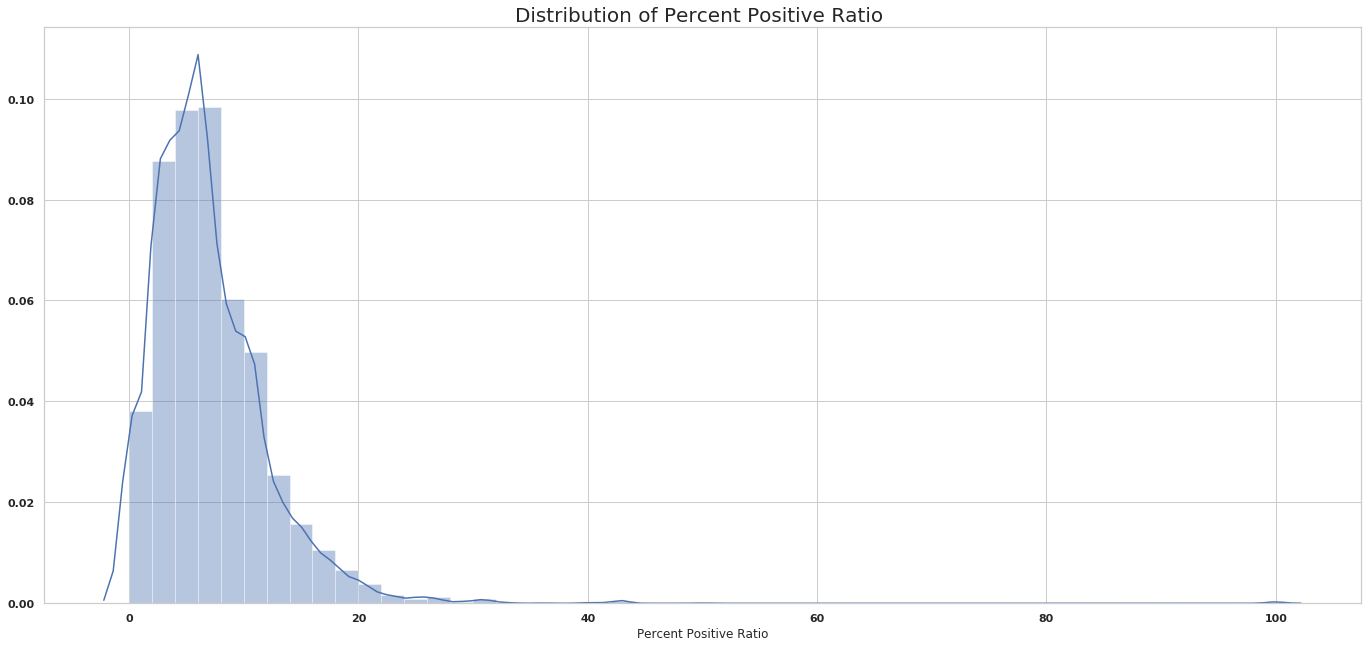

In [343]:
sns.distplot(df['percent_positive'])
plt.title('Distribution of Percent Positive Ratio ', fontsize=20)
plt.rcParams['figure.figsize'] = (20,10) # changes plot size
plt.xlabel('Percent Positive Ratio')
plt.rc(group='font',**font )
plt.tight_layout()
plt.savefig(f'{graphics_path}Distribution of Positivity Ratio({date_today}).png')

<header>
 <h1 style="text-align:center">Florida COVID-19 Trajectory</h1>
</header>

In [51]:
week_case = pd.DataFrame(df.groupby('week').new_cases.agg(['median', 'mean', 'var']))
week_case['week'] = week_case.index
# Calculating the Weekly median Percent Positive Ratio
week_per = pd.DataFrame(df.groupby('week').percent_positive.agg(['median', 'var']))
week_per['week'] = week_per.index

In [ ]:
week

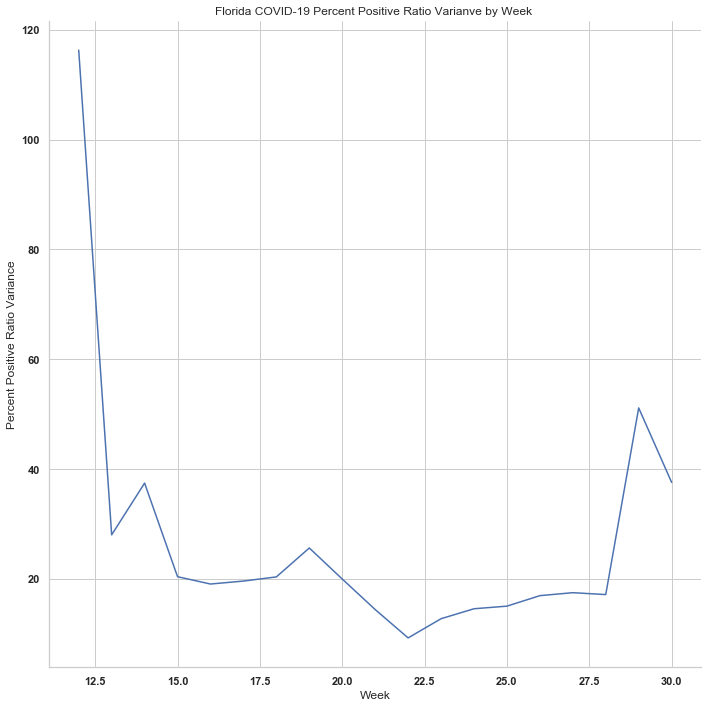

In [287]:
sns.set(style='whitegrid')
sns.relplot(x='week',  y= 'var',kind= 'line', estimator = 'mean', height=10, aspect=1, data= week_per )
plt.title('Florida COVID-19 Percent Positive Ratio Varianve by Week ')
plt.tight_layout()
plt.ylabel('Percent Positive Ratio Variance')
plt.xlabel('Week')
plt.savefig(f'{graphics_path}Median Weekly Percent Positive Ratio Variance ({date_today}).png')

In [347]:
phase1.week,  phase2.week

(19, 23)

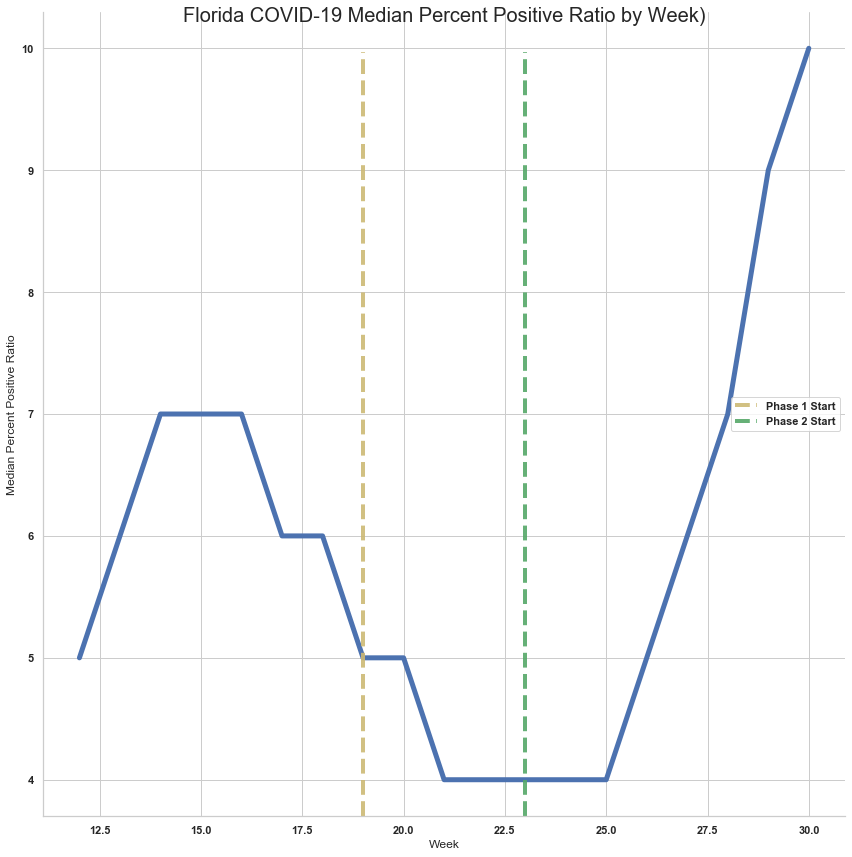

In [345]:
sns.set(style='whitegrid')
sns.relplot(x='week',  y= 'median' ,kind= 'line', estimator=None ,lw=5, height=12, aspect=1, data= week_per)
plt.tight_layout()
plt.axvline(phase1.week, color='y', lw=4,  alpha = .9, label='Phase 1 Start', linestyle= '--', ymax=.95)
plt.axvline(phase2.week, color='g', lw=4,  alpha = .9, label='Phase 2 Start', linestyle= '--', ymax=.95)
plt.ylabel('Median Percent Positive Ratio')
plt.legend(loc='center right')
plt.xlabel('Week')
plt.title('Florida COVID-19 Median Percent Positive Ratio by Week)',pad=-10,fontsize=20)
plt.savefig(f'{graphics_path}Median Weekly Percet Positive Ratio({date_today}).png')

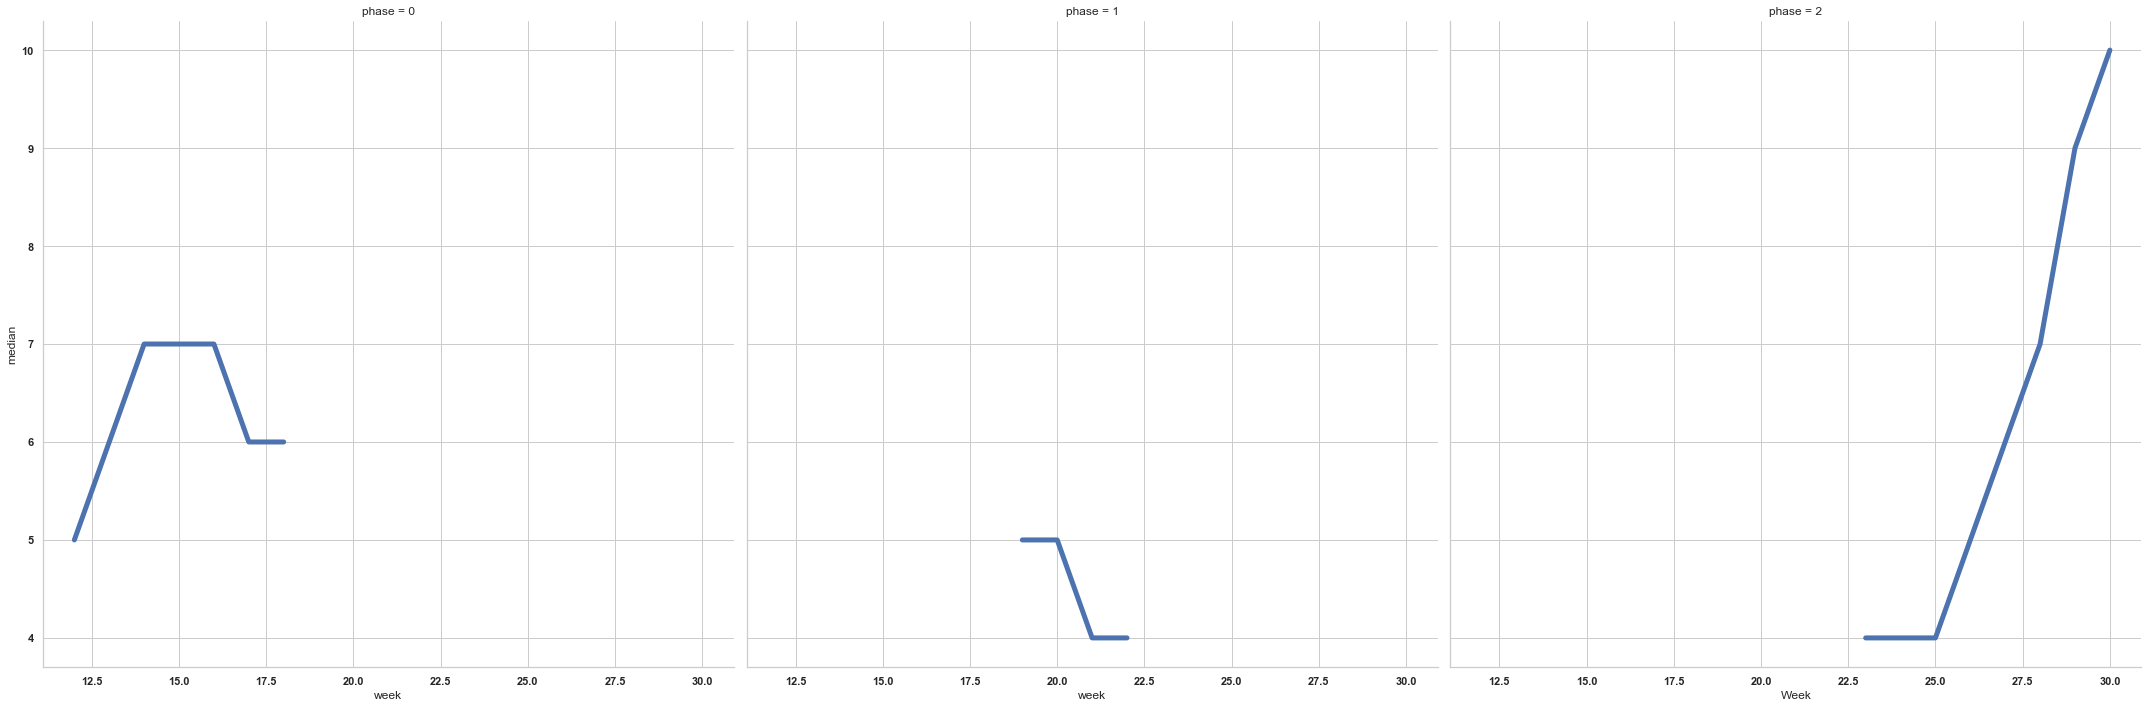

In [328]:
sns.set(style='whitegrid')
sns.relplot(x='week',  y= 'median' ,kind= 'line', estimator=None ,lw=5 ,height=10, aspect=1, data= week_per, col='phase')
plt.tight_layout()
plt.ylabel('Percent Positive Ratio')
plt.xlabel('Week')
# plt.title('Florida COVID-19 Median Percent Positive Ratio by Week)')
plt.savefig(f'{graphics_path}Median Weekly Percent Positive Ratio by Reopen Phase({date_today}).png')

<header>
 <h1 style="text-align:center">Florida COVID-19 Change Point Analysis</h1>
</header>

### Attempting to detect changes in the trend of Florida's COVID-19 positive test ratio


<img src="../Change Point graphics/CP_PP_Med.png" alt="RWJ Logo" width="1000"/>

> Change Points Index: 2  5  7  9 14

> Change Point Weeks: 13, 16, 18, 20, 25

### R Code:

`pp.pelt=cpt.meanvar(pp['median'],method='SegNeigh',minseglen=1 )`

`cpts(pp.pelt)`

`plot(pp.pelt, main='Change Point Analysis FL Weekly COVID-19 Percent Pos. Ratio', col='Black' ,ylab= 'Median')`


# Defining States for Multi-State Model
- ## 0 = Palteau
- ## 1 = Increasing  
- ## 2 = Decrease

In [267]:
cp = [13, 16, 18, 20, 25]

week_per['cp'] = week_per['week'].apply(lambda x: 1 if x in cp else 0)
# week_per.loc[week_per['median']]

week_per['prev_cp'] = week_per['cp'].shift(1)
week_per['prev_median'] = week_per['median'].shift(1)

week_per['stage'] = 0# 0 = palteau, 1 = increase, 2 = decrease
week_per.loc[(week_per['median'] > week_per['prev_median']) & (week_per['prev_cp'] == 1), 'stage' ] = 1
week_per.loc[(week_per['median'] < week_per['prev_median']) & (week_per['prev_cp'] == 1), 'stage' ] = 2
week_per.loc[week_per['week'] > 26, 'stage' ] = 1
# week_per.filter(items=['median','prev_median', 'cp' ,'prev_cp','stage'])
week_per.columns
week_per.drop(labels=['prev_median', 'prev_cp'], axis =1,inplace=True)

In [271]:

week_per.loc[week_per['stage'] == 0]
week_per.to_excel(f'{data_path}Change Point Analysis State Level Median PP.xlsx', index=False)
week_case.to_excel(f'{data_path}Change Point Analysis State Level Avg Case.xlsx', index=False)

<header>
 <h1 style="text-align:center">Transition Model Data Set State-level</h1>
</header>

![USF Logo](../Presentation_Graphics/Transition_table.png)

![USF Logo](../Presentation_Graphics/PP_Transition_Diagram.png)

<header>
 <h1 style="text-align:center">Conclusions</h1>
</header>

- Florida's changes in COVID-19 test PPR seem to lend itself to change point analysis and use in MSM
- The selected methodology seems to be a functional method of identifying changes in COVID-19 median PPR. 
- There does seem to be potential relationship between the state reopening phase and median PPR.
- Florida has seen a recent spike in COVID-19 cases
- Python useful tool for data collection and analysis

# Next Steps:

> 1. Conduct a change point analysis to detect changes in county level PPR 
2. Run MSM with state & county level data
3. Attempt to create a multi-level model with state & county data included

<header>
 <h1 style="text-align:center">Send Questions to:</h1>
    <h2 style="text-align:center">Daniel Chacreton MPH, CIC, CPH</h2>
    <h2 style="text-align:center">Doctoral Student and Graduate Research Assistant</h2>
    <h3 style="text-align:center">University of South Florida</h3>
    <h3 style="text-align:center">College of Public Health</h3>
    <h3 style="text-align:center">Email: dchacret@usf.edu</h3>
    <h3 style="text-align:center">Phone: (561)809-2686 </h3>
</header>

![USF Logo](../Presentation_Graphics/usf_brand_9-5-18_3.jpg)